In [2]:
# 기본 라이브러리
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

# 데이터 전처리 및 모델링 관련 라이브러리
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import classification_report, confusion_matrix

# PyTorch 관련 라이브러리
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary

# 그래프 스타일 설정
plt.style.use('seaborn-v0_8-whitegrid')

In [3]:
# PyTorch 학습을 위한 장치 설정 (GPU 우선 사용)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

# 하이퍼파라미터 설정
BATCH_SIZE = 64
EPOCHS = 50
LEARNING_RATE = 0.001
VALIDATION_SPLIT = 0.2

Using device: cuda


In [4]:
# 데이터셋 불러오기
# full_data.csv 파일이 현재 작업 디렉토리에 있어야 합니다.
try:
    df = pd.read_csv('full_data.csv')
    print("Data loaded successfully!")
except FileNotFoundError:
    print("Error: 'full_data.csv' not found. Please make sure the file is in the correct directory.")

# 데이터의 첫 5행 확인
df.head()

Data loaded successfully!


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


In [5]:
# 데이터의 전반적인 정보 확인 (컬럼별 데이터 타입, Non-null 개수 등)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4981 entries, 0 to 4980
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             4981 non-null   object 
 1   age                4981 non-null   float64
 2   hypertension       4981 non-null   int64  
 3   heart_disease      4981 non-null   int64  
 4   ever_married       4981 non-null   object 
 5   work_type          4981 non-null   object 
 6   Residence_type     4981 non-null   object 
 7   avg_glucose_level  4981 non-null   float64
 8   bmi                4981 non-null   float64
 9   smoking_status     4981 non-null   object 
 10  stroke             4981 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 428.2+ KB


In [6]:
# 결측치 확인
print("Missing values before handling:")
df.isnull().sum()

Missing values before handling:


,0
gender,0
age,0
hypertension,0
heart_disease,0
ever_married,0
work_type,0
Residence_type,0
avg_glucose_level,0
bmi,0
smoking_status,0


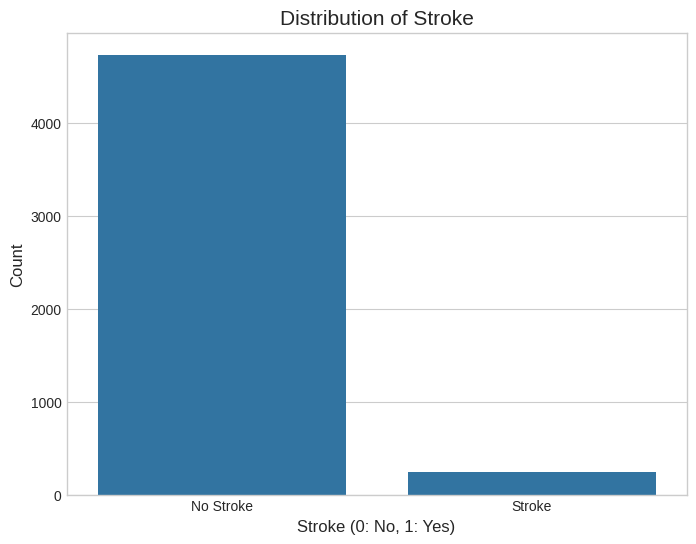

In [7]:
# 타겟 변수인 'stroke'의 분포 확인
plt.figure(figsize=(8, 6))
sns.countplot(x='stroke', data=df)
plt.title('Distribution of Stroke', fontsize=15)
plt.xlabel('Stroke (0: No, 1: Yes)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks([0, 1], ['No Stroke', 'Stroke'])
plt.savefig('stroke_distribution.png')
plt.show()

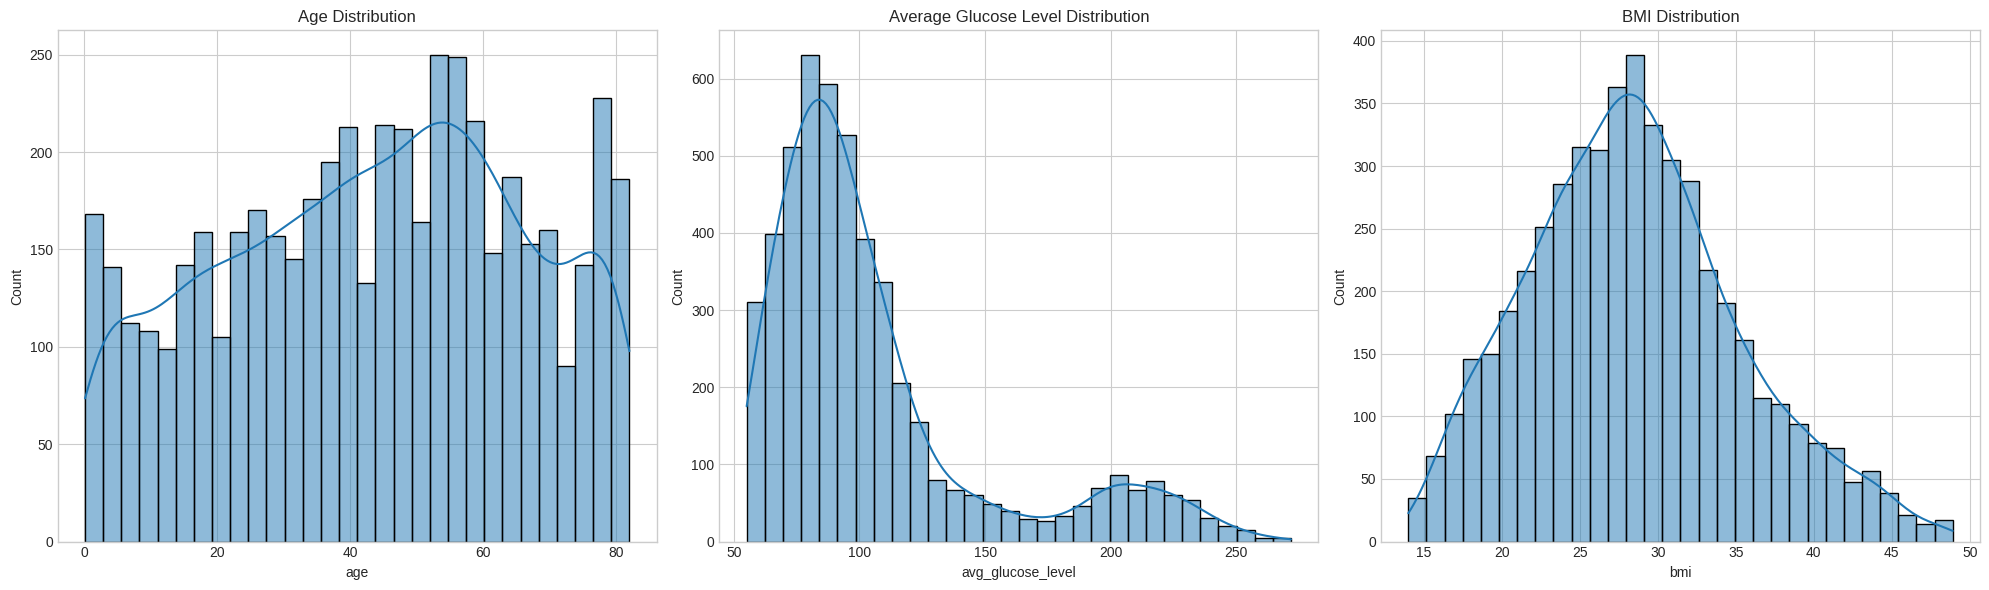

In [8]:
# 주요 수치형 데이터(나이, 평균 혈당, BMI)의 분포 확인
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
sns.histplot(df['age'], kde=True, ax=axes[0], bins=30)
axes[0].set_title('Age Distribution')

sns.histplot(df['avg_glucose_level'], kde=True, ax=axes[1], bins=30)
axes[1].set_title('Average Glucose Level Distribution')

sns.histplot(df['bmi'], kde=True, ax=axes[2], bins=30)
axes[2].set_title('BMI Distribution')

plt.tight_layout()
plt.savefig('numerical_distributions.png')
plt.show()

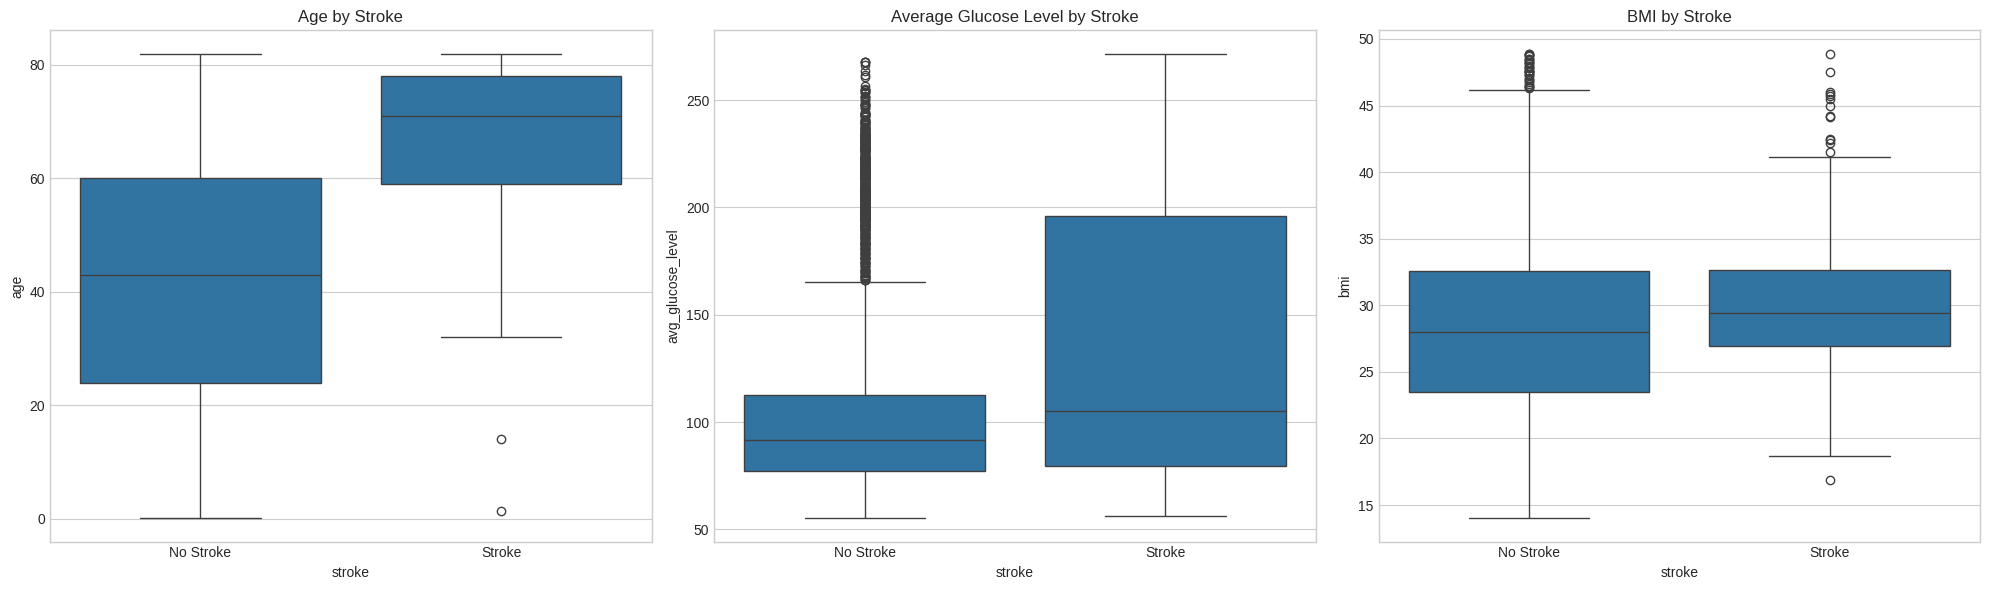

In [9]:
# 뇌졸중 발병 여부에 따른 주요 수치형 데이터 분포 비교
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
sns.boxplot(x='stroke', y='age', data=df, ax=axes[0])
axes[0].set_title('Age by Stroke')
axes[0].set_xticklabels(['No Stroke', 'Stroke'])


sns.boxplot(x='stroke', y='avg_glucose_level', data=df, ax=axes[1])
axes[1].set_title('Average Glucose Level by Stroke')
axes[1].set_xticklabels(['No Stroke', 'Stroke'])

sns.boxplot(x='stroke', y='bmi', data=df, ax=axes[2])
axes[2].set_title('BMI by Stroke')
axes[2].set_xticklabels(['No Stroke', 'Stroke'])

plt.tight_layout()
plt.savefig('numerical_vs_stroke.png')
plt.show()

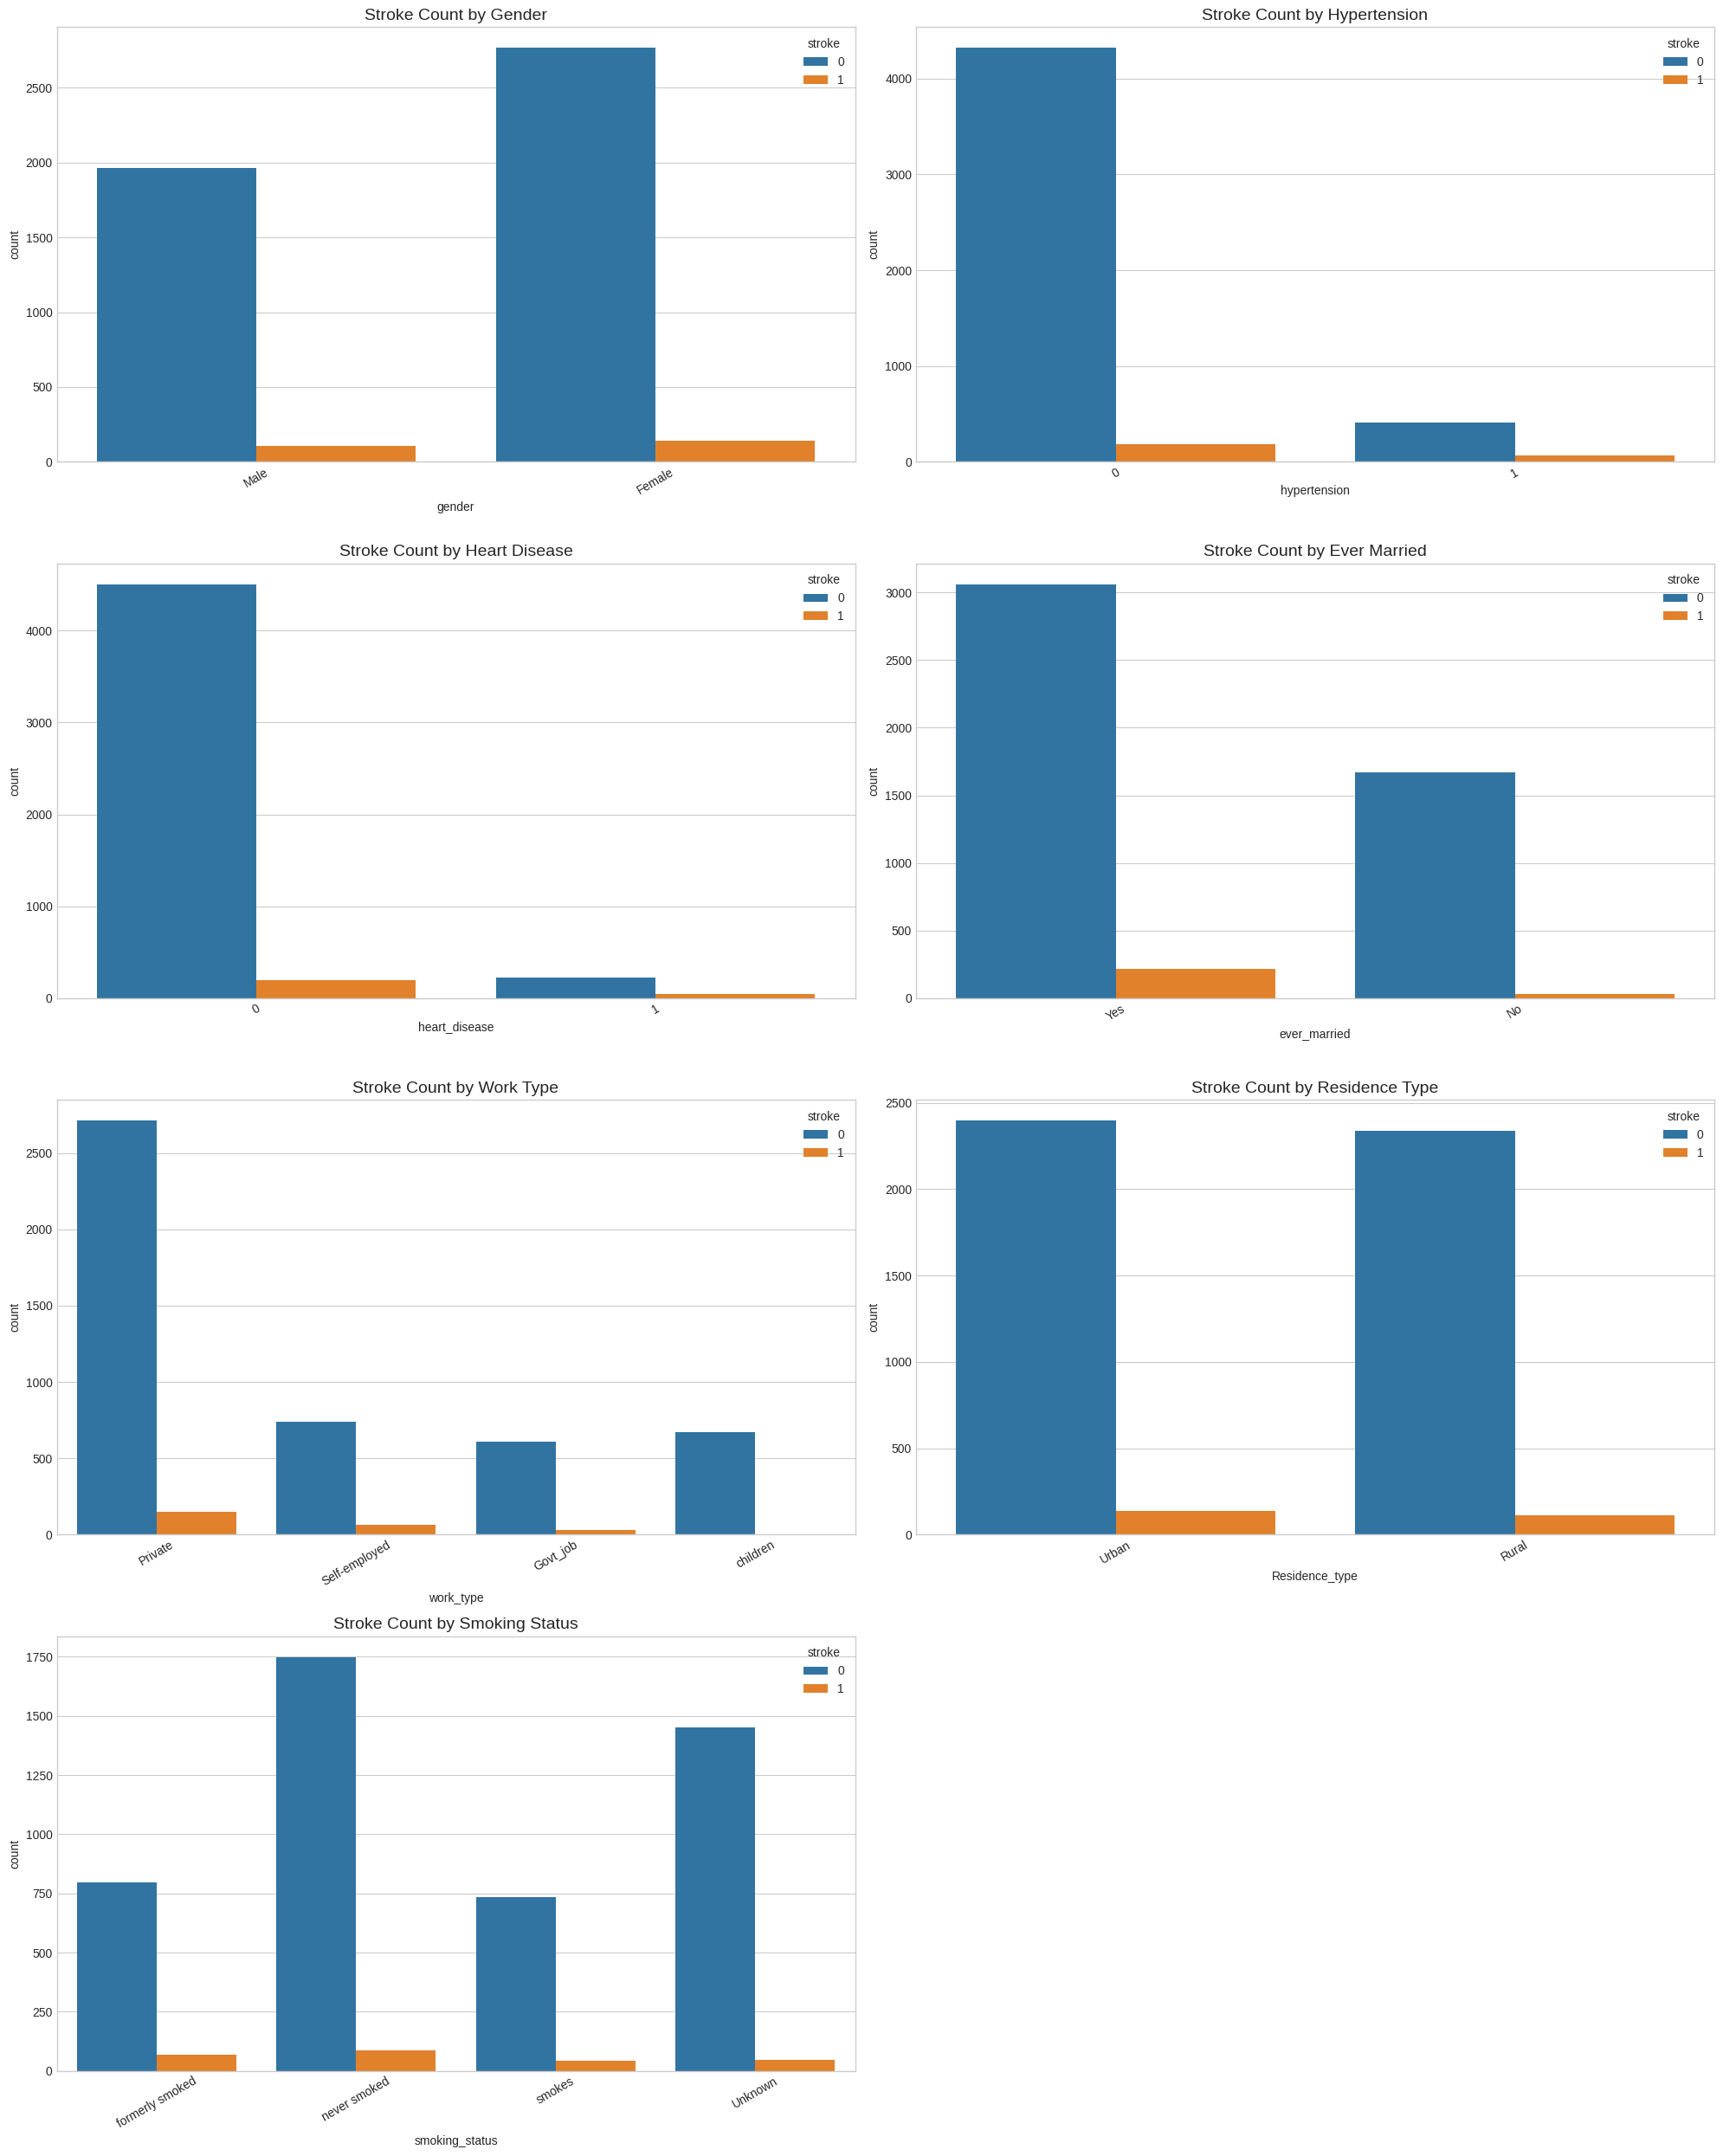

In [10]:
# 주요 범주형 데이터와 뇌졸중 발병률 관계 분석
categorical_features = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
fig, axes = plt.subplots(4, 2, figsize=(20, 25))
axes = axes.flatten()

for i, col in enumerate(categorical_features):
    sns.countplot(x=col, hue='stroke', data=df, ax=axes[i])
    axes[i].set_title(f'Stroke Count by {col.replace("_", " ").title()}', fontsize=14)
    axes[i].tick_params(axis='x', rotation=30)

# 마지막 subplot이 비어있으면 숨김
if len(categorical_features) < len(axes):
    axes[-1].set_visible(False)

plt.tight_layout()
plt.savefig('categorical_vs_stroke.png')
plt.show()

In [11]:
# 'bmi' 컬럼의 결측치를 중앙값(median)으로 대체
bmi_median = df['bmi'].median()
df['bmi'].fillna(bmi_median, inplace=True)
print(f"'bmi' missing values filled with median: {bmi_median}")

# 'gender'가 'Other'인 행은 1개 뿐이므로 분석에서 제외
df = df[df['gender'] != 'Other']
print("'gender' with value 'Other' has been removed.")

print("\nMissing values after handling:")
df.isnull().sum()

'bmi' missing values filled with median: 28.1
'gender' with value 'Other' has been removed.

Missing values after handling:


,0
gender,0
age,0
hypertension,0
heart_disease,0
ever_married,0
work_type,0
Residence_type,0
avg_glucose_level,0
bmi,0
smoking_status,0


In [12]:
# 원-핫 인코딩을 적용할 범주형 변수 목록
categorical_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

# pandas의 get_dummies 함수를 사용하여 원-핫 인코딩 수행
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

print("Shape of dataframe after One-Hot Encoding:", df_encoded.shape)
df_encoded.head()

Shape of dataframe after One-Hot Encoding: (4981, 15)


,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Male,ever_married_Yes,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,228.69,36.6,1,True,True,True,False,False,True,True,False,False
1,80.0,0,1,105.92,32.5,1,True,True,True,False,False,False,False,True,False
2,49.0,0,0,171.23,34.4,1,False,True,True,False,False,True,False,False,True
3,79.0,1,0,174.12,24.0,1,False,True,False,True,False,False,False,True,False
4,81.0,0,0,186.21,29.0,1,True,True,True,False,False,True,True,False,False


In [13]:
# 뇌졸중 발병(stroke=1)과 비발병(stroke=0) 데이터 분리
stroke_df = df_encoded[df_encoded['stroke'] == 1]
no_stroke_df = df_encoded[df_encoded['stroke'] == 0]

# 다수 클래스(비발병) 데이터를 소수 클래스(발병) 데이터 개수에 맞춰 무작위로 샘플링
no_stroke_downsampled = no_stroke_df.sample(n=len(stroke_df), random_state=42)

# 두 데이터프레임을 합쳐 균형잡힌 데이터셋 생성
balanced_df = pd.concat([stroke_df, no_stroke_downsampled])

# 데이터셋을 무작위로 섞음
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

print("Data distribution after undersampling:")
print(balanced_df['stroke'].value_counts())

Data distribution after undersampling:
stroke
0    248
1    248
Name: count, dtype: int64


In [14]:
# 특성(X)과 타겟(y) 데이터 분리
X = balanced_df.drop('stroke', axis=1)
y = balanced_df['stroke']

# 학습 데이터와 검증 데이터로 분할
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=VALIDATION_SPLIT, random_state=42, stratify=y
)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_valid.shape}")

Training data shape: (396, 14)
Validation data shape: (100, 14)


In [15]:
# 스케일링을 적용할 수치형 변수 목록
numerical_cols = ['age', 'avg_glucose_level', 'bmi']

# RobustScaler 객체 생성 및 학습 데이터에 적용
scaler = RobustScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_valid[numerical_cols] = scaler.transform(X_valid[numerical_cols])

print("Data scaling complete.")
X_train.head()

Data scaling complete.


,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Male,ever_married_Yes,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
39,0.25000,1,0,-0.000795,-0.075710,False,True,True,False,False,True,False,True,False
205,0.28125,1,1,-0.269545,0.958991,False,False,False,True,False,True,False,True,False
152,0.59375,1,0,0.888977,-0.656151,False,True,False,True,False,False,False,True,False
470,-0.25000,0,0,0.172159,0.100946,True,True,True,False,False,False,False,True,False
158,-1.12500,0,0,-0.251250,-0.984227,True,True,True,False,False,False,False,False,True


In [17]:
# 데이터를 PyTorch Tensor 형태로 변환 (데이터 타입 명시적 변환 추가)
X_train_tensor = torch.FloatTensor(X_train.values.astype(np.float32)).to(device)
y_train_tensor = torch.LongTensor(y_train.values).to(device)
X_valid_tensor = torch.FloatTensor(X_valid.values.astype(np.float32)).to(device)
y_valid_tensor = torch.LongTensor(y_valid.values).to(device)

# DataLoader 생성
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("Data converted to PyTorch Tensors and DataLoaders are ready.")
print("Input feature size:", X_train.shape[1])

Data converted to PyTorch Tensors and DataLoaders are ready.
Input feature size: 14


In [18]:
class StrokePredictor(nn.Module):
    def __init__(self, n_features):
        super(StrokePredictor, self).__init__()
        self.fc1 = nn.Linear(n_features, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)
        self.out = nn.Linear(32, 2)  # 2 classes: stroke or not

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.out(x)
        return x

# 모델 인스턴스 생성 및 장치로 이동
n_features = X_train.shape[1]
model = StrokePredictor(n_features).to(device)

# 모델 구조 확인
summary(model, input_size=(n_features,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]           1,920
       BatchNorm1d-2                  [-1, 128]             256
            Linear-3                   [-1, 64]           8,256
       BatchNorm1d-4                   [-1, 64]             128
            Linear-5                   [-1, 32]           2,080
       BatchNorm1d-6                   [-1, 32]              64
            Linear-7                    [-1, 2]              66
Total params: 12,770
Trainable params: 12,770
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.05
Estimated Total Size (MB): 0.05
----------------------------------------------------------------


In [19]:
# 손실 함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [20]:
# 모델 학습을 위한 루프 실행
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

for epoch in range(EPOCHS):
    # --- Training Phase ---
    model.train()
    train_loss, correct_train, total_train = 0.0, 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    history['train_loss'].append(avg_train_loss)
    history['train_acc'].append(train_accuracy)

    # --- Validation Phase ---
    model.eval()
    val_loss, correct_val, total_val = 0.0, 0, 0

    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(valid_loader)
    val_accuracy = 100 * correct_val / total_val
    history['val_loss'].append(avg_val_loss)
    history['val_acc'].append(val_accuracy)

    print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

print("\nTraining finished.")

Epoch [1/50], Train Loss: 0.6642, Train Acc: 56.82%, Val Loss: 0.6783, Val Acc: 61.00%
Epoch [2/50], Train Loss: 0.5165, Train Acc: 77.27%, Val Loss: 0.6367, Val Acc: 68.00%
Epoch [3/50], Train Loss: 0.4984, Train Acc: 78.28%, Val Loss: 0.5932, Val Acc: 68.00%
Epoch [4/50], Train Loss: 0.4514, Train Acc: 79.29%, Val Loss: 0.5772, Val Acc: 68.00%
Epoch [5/50], Train Loss: 0.4720, Train Acc: 81.57%, Val Loss: 0.5848, Val Acc: 69.00%
Epoch [6/50], Train Loss: 0.4457, Train Acc: 80.05%, Val Loss: 0.6035, Val Acc: 69.00%
Epoch [7/50], Train Loss: 0.4178, Train Acc: 82.58%, Val Loss: 0.6183, Val Acc: 67.00%
Epoch [8/50], Train Loss: 0.3844, Train Acc: 84.09%, Val Loss: 0.6240, Val Acc: 67.00%
Epoch [9/50], Train Loss: 0.3681, Train Acc: 85.86%, Val Loss: 0.6259, Val Acc: 68.00%
Epoch [10/50], Train Loss: 0.4038, Train Acc: 84.60%, Val Loss: 0.6186, Val Acc: 67.00%
Epoch [11/50], Train Loss: 0.3562, Train Acc: 85.86%, Val Loss: 0.6259, Val Acc: 64.00%
Epoch [12/50], Train Loss: 0.3438, Train 

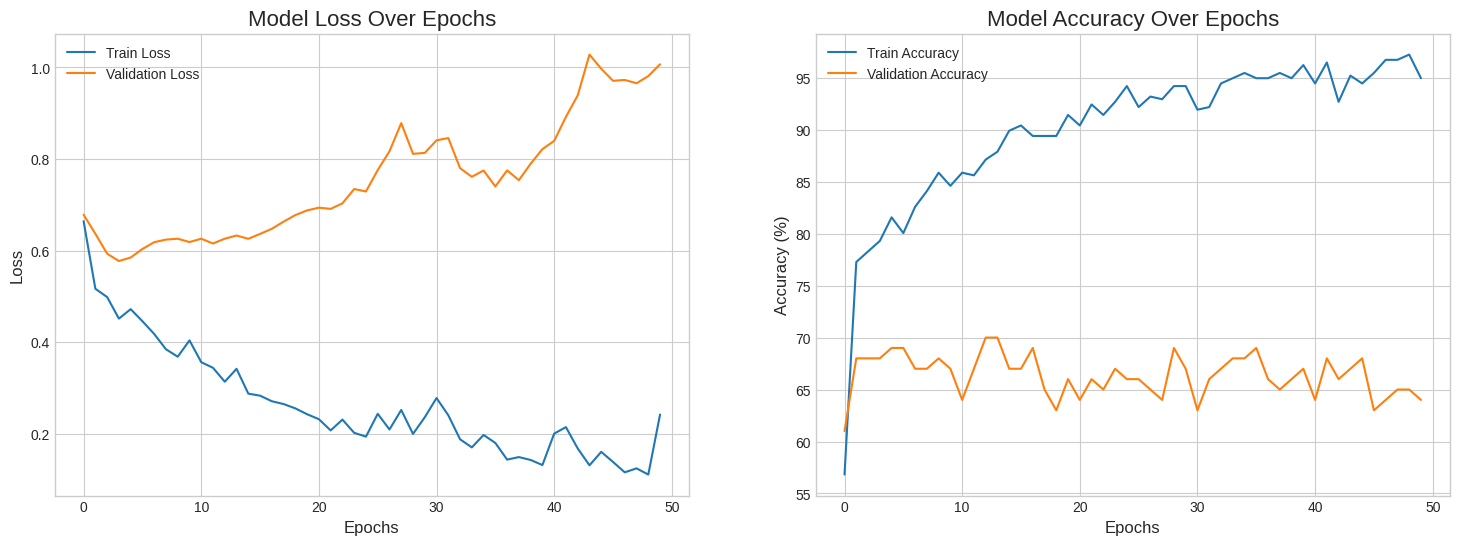

In [21]:
# 학습 과정의 손실 및 정확도 변화 시각화
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Loss plot
ax1.plot(history['train_loss'], label='Train Loss')
ax1.plot(history['val_loss'], label='Validation Loss')
ax1.set_title('Model Loss Over Epochs', fontsize=16)
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.legend()

# Accuracy plot
ax2.plot(history['train_acc'], label='Train Accuracy')
ax2.plot(history['val_acc'], label='Validation Accuracy')
ax2.set_title('Model Accuracy Over Epochs', fontsize=16)
ax2.set_xlabel('Epochs', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.legend()

plt.savefig('learning_curves.png')
plt.show()

In [22]:
# 검증 데이터셋에 대한 예측 수행
model.eval()
y_pred_list = []
with torch.no_grad():
    for inputs, _ in valid_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, y_pred = torch.max(outputs, 1)
        y_pred_list.extend(y_pred.cpu().numpy())

y_pred_array = np.array(y_pred_list)
y_true_array = y_valid.values

In [23]:
# Classification Report 출력 (정밀도, 재현율, F1-score)
class_names = ['No Stroke', 'Stroke']
print("Classification Report:\n")
print(classification_report(y_true_array, y_pred_array, target_names=class_names))

Classification Report:

              precision    recall  f1-score   support

   No Stroke       0.63      0.68      0.65        50
      Stroke       0.65      0.60      0.62        50

    accuracy                           0.64       100
   macro avg       0.64      0.64      0.64       100
weighted avg       0.64      0.64      0.64       100



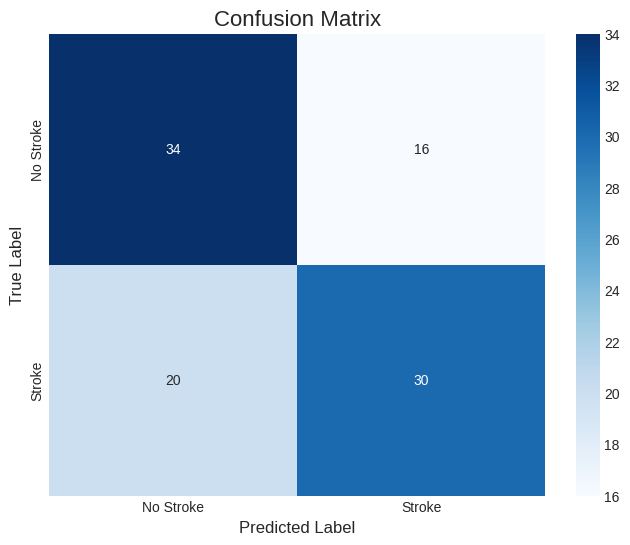

In [24]:
# Confusion Matrix 계산
cm = confusion_matrix(y_true_array, y_pred_array)

# Confusion Matrix 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.savefig('confusion_matrix.png')
plt.show()